# **Flan-t5 Model**
This notebook uses Google Flan-t5, fine-tuned with Low Rank Adaptation (LoRA) and LangChain framework, to perform sentiment analysis on our dataset, thereby predicting stock price trends.

The model architecture can be found in the file `models/llmbase.py`, specifically in class `LLMStockPredictBase`.

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from langchain.prompts import PromptTemplate
from collections import Counter
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
)

from helpers.dataset import get_llm_datasets
from models import LLMStockPredictBase

### (SHARED) Model and Dataset Parameters

In [9]:
from helpers import *

# Model hyperparameters
max_chunk_length = 256
max_chunks = 8
batch_size = 4
num_epochs = 45
learning_rate = 2e-5
aggregation_method = 'attention'
early_stopping_patience = 6
use_wordnet = True
focal_gamma = 2.0

# dataset and dataloaders
df = pd.read_csv(dataset_path)
(_, train_df), (_, val_df), (_, test_df) = get_split_datasets(
    df, use_wordnet=use_wordnet, max_chunk_length=max_chunk_length, max_chunks=max_chunks,
)

# 1. Flan-t5 Model
As discussed, we will be using LoRA to efficiently generate the weight updates.

In [21]:
model_name = "google/flan-t5-base"
train_dataset, val_dataset = get_llm_datasets(train_df, val_df, model_name)
model = LLMStockPredictBase(model_name)

Map: 100%|██████████| 590/590 [03:42<00:00,  2.65 examples/s]
Device set to use cpu
The model 'PeftModelForSeq2SeqLM' is not supported for text2text-generation. Supported models are ['BartForConditionalGeneration', 'BigBirdPegasusForConditionalGeneration', 'BlenderbotForConditionalGeneration', 'BlenderbotSmallForConditionalGeneration', 'EncoderDecoderModel', 'FSMTForConditionalGeneration', 'GPTSanJapaneseForConditionalGeneration', 'LEDForConditionalGeneration', 'LongT5ForConditionalGeneration', 'M2M100ForConditionalGeneration', 'MarianMTModel', 'MBartForConditionalGeneration', 'MT5ForConditionalGeneration', 'MvpForConditionalGeneration', 'NllbMoeForConditionalGeneration', 'PegasusForConditionalGeneration', 'PegasusXForConditionalGeneration', 'PLBartForConditionalGeneration', 'ProphetNetForConditionalGeneration', 'Qwen2AudioForConditionalGeneration', 'SeamlessM4TForTextToText', 'SeamlessM4Tv2ForTextToText', 'SwitchTransformersForConditionalGeneration', 'T5ForConditionalGeneration', 'UMT

# 2. Fine-tuning

In [22]:
print(train_dataset[0].keys())
print(val_dataset[0].keys())

dict_keys(['input', 'output', 'input_ids', 'attention_mask', 'labels'])
dict_keys(['input', 'output', 'input_ids', 'attention_mask', 'labels'])


In [24]:
save_dir = model_path + './flant5'

model.train(
    train_dataset,
    val_dataset,
    save=True,
    save_dir=save_dir,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=2,
    logging_dir="./logs",
    save_strategy="no",
    eval_strategy="no",
    label_names=["labels"],
    fp16=True,
    load_best_model_at_end=True,
    report_to="none"
)


TypeError: T5ForConditionalGeneration.forward() got an unexpected keyword argument 'num_items_in_batch'

In [25]:
template = """
You are a reliable and excellent financial expert who's been doing sentiment analysis on social media to capture \
its correlation with stock price trends. You are given the following social media posts (each post is separated by \
the character ' [SEP] ', ordered by the time it was created), on the same given date and stock code:

Date: {date}
Stock: {stock}
Posts: "{post}"

The first step you should do is classify the sentiment for each post.
The second step is, based on all of these posts, the given date, and the stock code, predict the stock price trend.
You are only allowed to give predictions based on data prior to the given date.
The third step is to provide your reasoning for your predictions.
Finally, with your reasoning, provide the finalized prediction of the stock price trend (either 'increase' or 'decrease').

Respond in the following JSON format:
- sentiments: the sentiment of each post, either 'negative' or 'positive',
- prediction: 'increase' or 'decrease',
- reasoning: your reasoning, 1-2 sentences long

Your answer:
"""

model.prompt_template_chain(template, input_variables=["date", "stock", "post"])

# 3. Performance Evaluation

### Prompt Template with 3D Inputs (date, stock, post)

In [26]:
def classify_with_voting(row, n_votes=3):
    predictions = []

    for i in range(n_votes):
        try:
            response = model.invoke({
                "date": str(row[date]),
                "stock": row[stock][:450],
                "post": row[post][:512]
            })
            # print(response)

            if "text" in response:
                predictions.append(response["text"].lower())
            else:
                print(f"❌ Run {i+1}: Missing 'prediction' key →", response)

        except Exception as e:
            print(f"❌ Run {i+1} failed for row:\n{row}")
            print("❌ Error:", e)

    if predictions:
        # count and return the majority prediction
        prediction_counts = Counter(predictions)
        majority = prediction_counts.most_common(1)[0][0]
        return majority
    else:
        return "unknown"

### Testing Results

In [27]:
test_df["majority_sentiment"] = test_df.apply(classify_with_voting, axis=1)

Token indices sequence length is longer than the specified maximum sequence length for this model (534 > 512). Running this sequence through the model will result in indexing errors


Accuracy : 0.5691
F1 Score : 0.5004
Precision: 0.5239
Recall   : 0.5173


<Figure size 600x600 with 0 Axes>

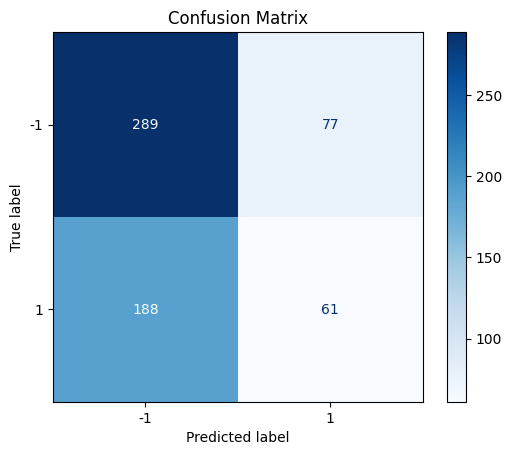

In [28]:
def map_prediction_to_label(prediction_str):
    pred = prediction_str.strip().lower()
    neg = pred.count("negative")
    pos = pred.count("positive")
    inc = pred.count("increase")
    dec = pred.count("decrease")
    if pos > neg:
        return 1
    else:
        return -1

y_true = test_df["label"]
y_pred = test_df["majority_sentiment"].apply(map_prediction_to_label)

# Metrics
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average="macro")
precision = precision_score(y_true, y_pred, average="macro")
recall = recall_score(y_true, y_pred, average="macro")

print(f"Accuracy : {accuracy:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")

labels = [-1, 1]

cm = confusion_matrix(y_true, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

plt.figure(figsize=(6, 6))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()

## 4. In-depth Evaluattion

In [47]:
import seaborn as sns

def evaluate_flan_llm_predictions(df, stock_column='stock', label_column='label', pred_column='majority_sentiment'):
    # Step 1: Calculate per-stock F1 scores
    metrics = []
    stock_groups = df.groupby(stock_column)
    
    for stock, group in stock_groups:
        if len(group) < 5:
            continue
        y_true = group[label_column].astype(int)
        y_pred = group[pred_column].apply(map_prediction_to_label)
        metrics.append({
            "Stock": stock,
            "F1 Score": f1_score(y_true, y_pred, average="binary"),
            "Precision": precision_score(y_true, y_pred),
            "Recall": recall_score(y_true, y_pred),
            "Accuracy": accuracy_score(y_true, y_pred),
            "Samples": len(group)
        })
    
    metrics_df = pd.DataFrame(metrics).sort_values("F1 Score", ascending=False).reset_index(drop=True)

    # Step 2: Plot F1 score by stock
    plt.figure(figsize=(12, 6))
    sns.barplot(x="Stock", y="F1 Score", data=metrics_df)
    plt.title("F1 Score by Stock")
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

    # Step 2.5: Print Stock Performance Table
    reordered_cols = ["Stock", "Accuracy", "F1 Score", "Precision", "Recall", "Samples"]
    print("\n=== Stock Performance Ranking (by F1 Score) ===")
    print(metrics_df.to_string(index=False, formatters={
        "Accuracy": "{:.6f}".format,
        "Precision": "{:.6f}".format,
        "Recall": "{:.6f}".format,
        "F1 Score": "{:.6f}".format,
        "Samples": "{:.1f}".format,
    }))

    # Step 3: Find best and worst performing stock
    best_stock = metrics_df.iloc[0]["Stock"]
    worst_stock = metrics_df.iloc[-1]["Stock"]

    # Step 4: Plot confusion matrices
    def plot_cm(stock_name, title, subplot_index):
        group = df[df[stock_column] == stock_name]
        y_true = group[label_column].astype(int)
        y_pred = group[pred_column].apply(map_prediction_to_label)
        cm = confusion_matrix(y_true, y_pred)
        plt.subplot(1, 2, subplot_index)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Decrease", "Increase"], yticklabels=["Decrease", "Increase"])
        plt.title(f"Confusion Matrix - {stock_name} ({title})")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
    
    plt.figure(figsize=(12, 5))
    plot_cm(best_stock, "Best", 1)
    plot_cm(worst_stock, "Worst", 2)
    plt.tight_layout()
    plt.show()

    return metrics_df

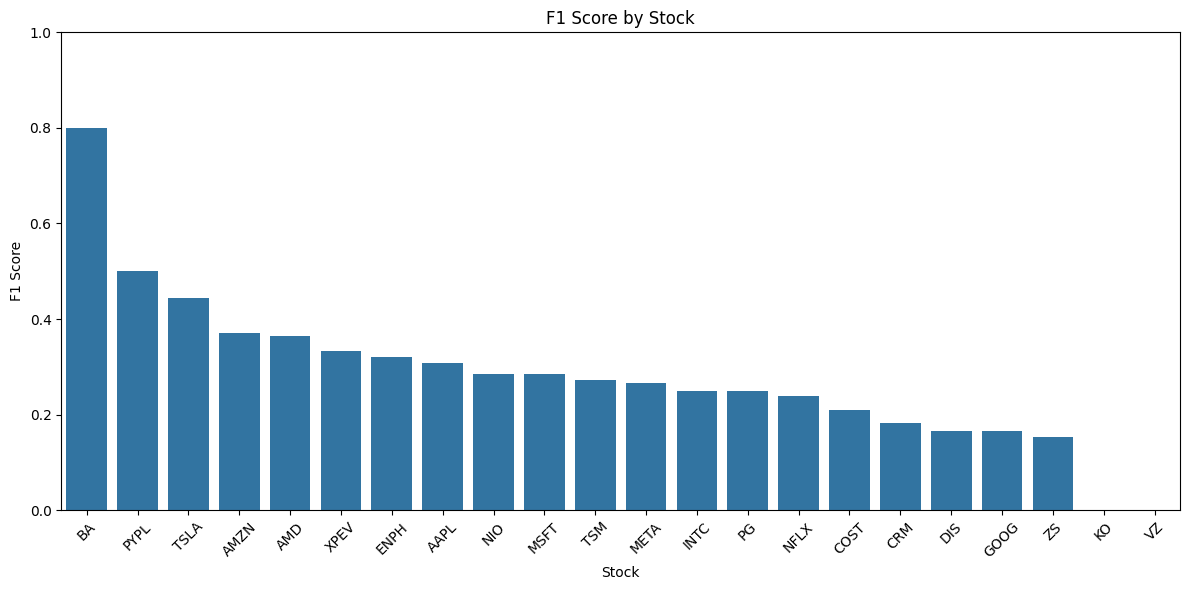


=== Stock Performance Ranking (by F1 Score) ===
Stock F1 Score Precision   Recall Accuracy Samples
   BA 0.800000  1.000000 0.666667 0.846154    13.0
 PYPL 0.500000  0.666667 0.400000 0.555556    18.0
 TSLA 0.444444  0.666667 0.333333 0.594595    37.0
 AMZN 0.370370  0.555556 0.277778 0.540541    37.0
  AMD 0.363636  0.571429 0.266667 0.621622    37.0
 XPEV 0.333333  1.000000 0.200000 0.555556     9.0
 ENPH 0.320000  0.666667 0.210526 0.468750    32.0
 AAPL 0.307692  0.444444 0.235294 0.513514    37.0
  NIO 0.285714  0.333333 0.250000 0.459459    37.0
 MSFT 0.285714  0.375000 0.230769 0.594595    37.0
  TSM 0.272727  0.333333 0.230769 0.567568    37.0
 META 0.266667  0.285714 0.250000 0.450000    20.0
 INTC 0.250000  0.200000 0.333333 0.760000    25.0
   PG 0.250000  0.200000 0.333333 0.675676    37.0
 NFLX 0.240000  0.375000 0.176471 0.387097    31.0
 COST 0.210526  0.285714 0.166667 0.444444    27.0
  CRM 0.181818  0.333333 0.125000 0.571429    21.0
  DIS 0.166667  0.333333 0.111111

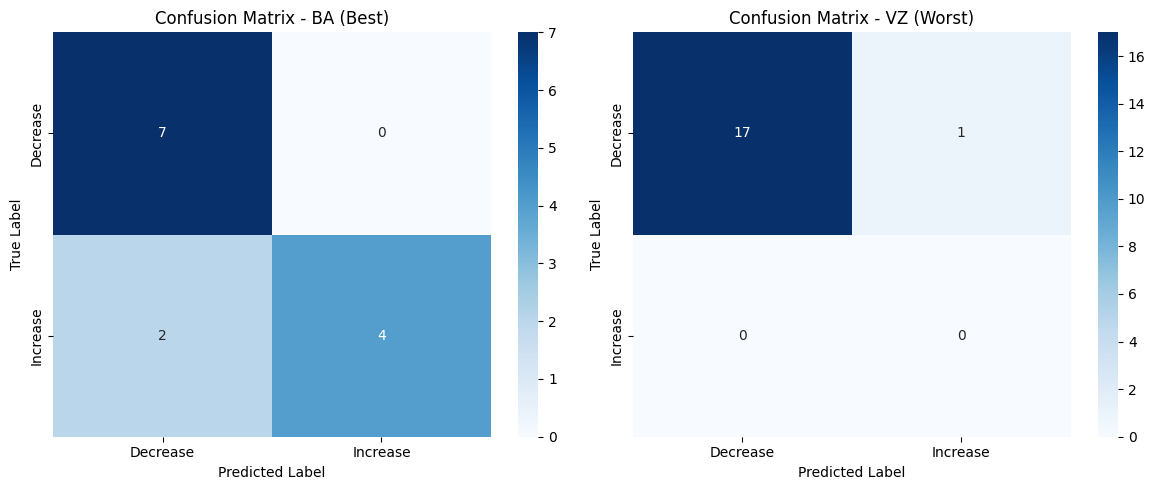



=== Time-Based Performance Analysis ===


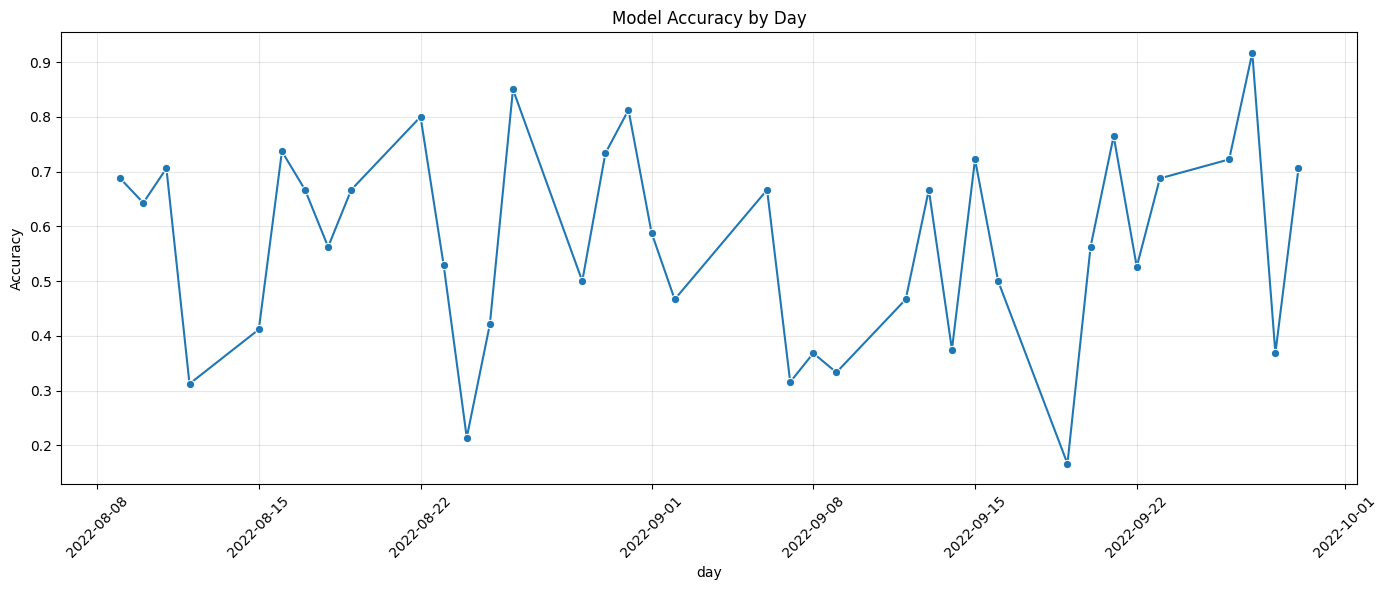

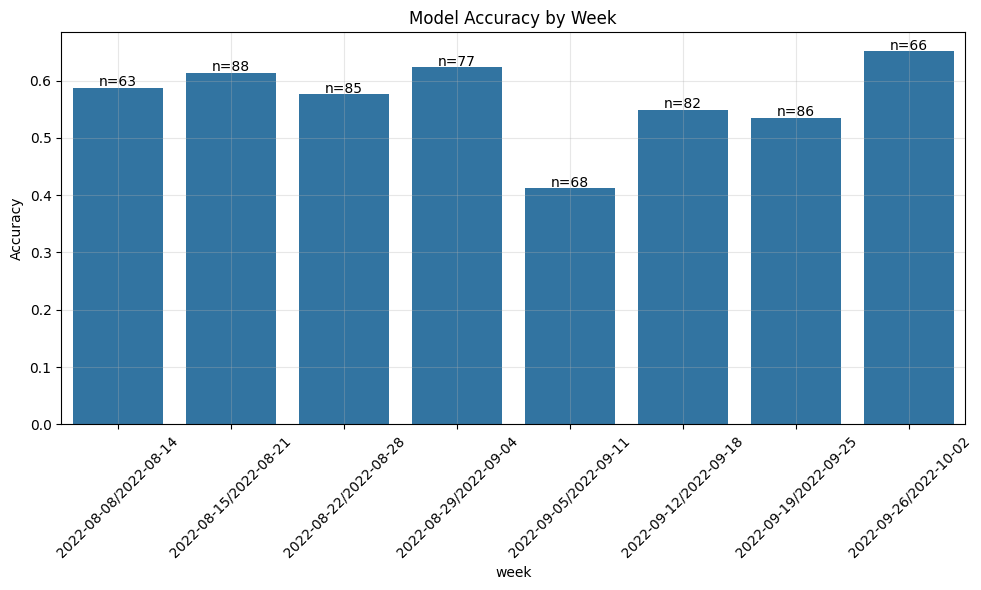


=== Worst Performing days ===
day: 2022-09-19 00:00:00, Accuracy: 0.17, Samples: 18
day: 2022-08-24 00:00:00, Accuracy: 0.21, Samples: 14
day: 2022-08-12 00:00:00, Accuracy: 0.31, Samples: 16


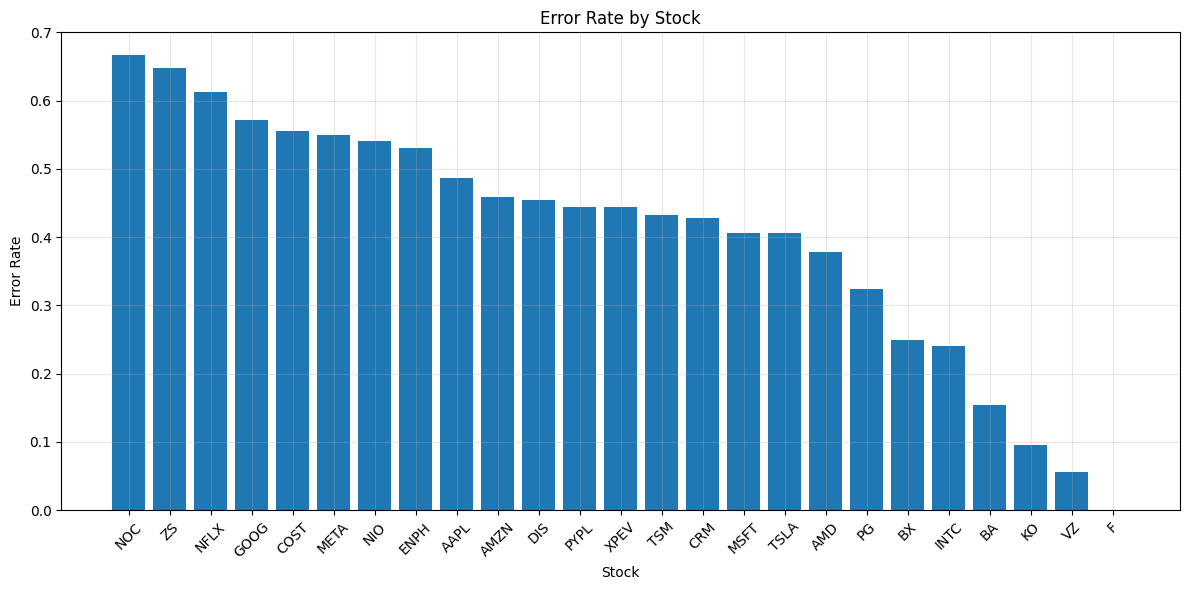


=== Stock-Specific Error Analysis ===

Stock: NOC - Error Rate: 0.67
Number of errors: 2 out of 3 samples
Common words in error cases:
  - 'noc': 2 occurrences
  - 'since': 1 occurrences
  - 'ukranian': 1 occurrences
  - 'war': 1 occurrences
  - 'northrop': 1 occurrences
  - 'grumman': 1 occurrences
  - 'corporation': 1 occurrences
  - 'has': 1 occurrences
  - 'hit': 1 occurrences

Example error cases:
  - True: Decrease, Predicted: Increase
    Text: Since the Ukranian war, Northrop Grumman Corporation, $NOC, has hit all time highs, up 27%.

  - True: Increase, Predicted: Decrease
    Text: Today's noteworthy breakouts, moves, and setups: (stocks in trend sorted by relative volume) $AXNX, $ENPH, $PRVA, $EVH, $RS, $QLYS, $SRTS, $NOC, $AR, ...


Stock: ZS - Error Rate: 0.65
Number of errors: 11 out of 17 samples
Common words in error cases:
  - 'zs': 12 occurrences
  - 'ddog': 10 occurrences
  - 'crwd': 9 occurrences
  - 'y': 8 occurrences
  - 's': 7 occurrences
  - 'snow': 7 occurrenc

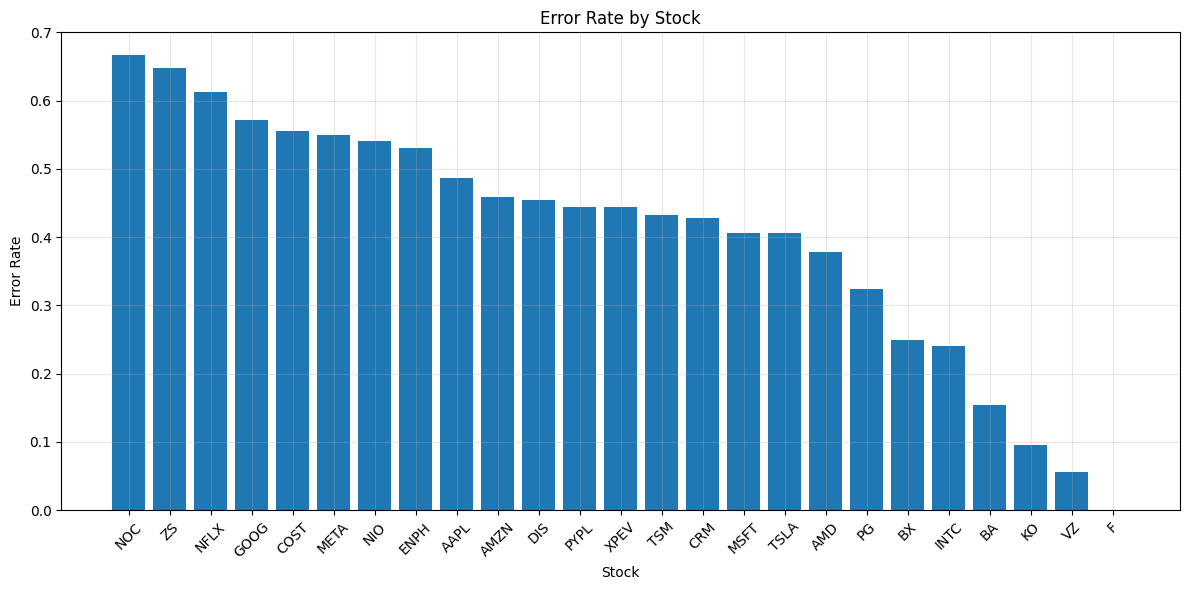


=== Stock-Specific Error Analysis ===

Stock: NOC - Error Rate: 0.67
Number of errors: 2 out of 3 samples
Common words in error cases:
  - 'noc': 2 occurrences
  - 'since': 1 occurrences
  - 'ukranian': 1 occurrences
  - 'war': 1 occurrences
  - 'northrop': 1 occurrences
  - 'grumman': 1 occurrences
  - 'corporation': 1 occurrences
  - 'has': 1 occurrences
  - 'hit': 1 occurrences

Example error cases:
  - True: Decrease, Predicted: Increase
    Text: Since the Ukranian war, Northrop Grumman Corporation, $NOC, has hit all time highs, up 27%.

  - True: Increase, Predicted: Decrease
    Text: Today's noteworthy breakouts, moves, and setups: (stocks in trend sorted by relative volume) $AXNX, $ENPH, $PRVA, $EVH, $RS, $QLYS, $SRTS, $NOC, $AR, ...


Stock: ZS - Error Rate: 0.65
Number of errors: 11 out of 17 samples
Common words in error cases:
  - 'zs': 12 occurrences
  - 'ddog': 10 occurrences
  - 'crwd': 9 occurrences
  - 'y': 8 occurrences
  - 's': 7 occurrences
  - 'snow': 7 occurrenc

,stock,error_rate,samples
17,NOC,0.666667,3
24,ZS,0.647059,17
15,NFLX,0.612903,31
10,GOOG,0.571429,35
5,COST,0.555556,27
13,META,0.550000,20
16,NIO,0.540541,37
8,ENPH,0.531250,32
0,AAPL,0.486486,37
2,AMZN,0.459459,37


In [54]:
results_df = evaluate_flan_llm_predictions(test_df)

# Time-based
print("\n\n=== Time-Based Performance Analysis ===")
test_df["label"] = test_df["label"].astype(int)
test_df["prediction"] = test_df["majority_sentiment"].apply(map_prediction_to_label)
test_df["correct"] = test_df["prediction"] == test_df["label"]
analyze_performance_by_time(test_df, date_column="trading_day")

# Stock specific 
_ = analyze_stock_specific_errors(eval_results['results_df'], stock_column=stock, post_column=post)
eval_results = {}
test_df["prediction"] = test_df["majority_sentiment"].apply(map_prediction_to_label)
test_df["correct"] = test_df["prediction"] == test_df["label"]

# Rename to match expected column names if needed
test_df["bert_label"] = test_df["label"]  # required by the error print format

# Store in eval_results
eval_results["results_df"] = test_df

analyze_stock_specific_errors(
    eval_results["results_df"],
    stock_column="stock",
    post_column="post"
)